In [1]:
# !pip install boto3 --quiet
# !pip install autogluon --quiet

In [2]:
# !apt-get install python3.12

In [3]:
# !python3.12 --version

In [4]:
# # prompt: use python version 3.12

# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 13
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12 11

# !sudo update-alternatives --config python3

# # Verify the Python version
# import sys
# sys.version

In [5]:
# !python --version

In [6]:
# #!git clone -b brian-etl-code https://github.com/The-Taimaka-Project/health-predictions.git
# !git clone https://github.com/The-Taimaka-Project/health-predictions.git

In [7]:
# import sys
# sys.path.append('/content/health-predictions')

In [8]:
%load_ext jupyter_black

In [9]:
import os
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
from autogluon.tabular import TabularDataset, TabularPredictor

# from google.colab import userdata

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from taimaka_health_predictions.inference.util import (
    DetnReaderWriter,
    ag_feature_generator,
    drop_feature_columns,
    lightgbm_train,
    select_features,
    split_detn_new_onset_medical_complication,
    strip_column_names,
)
from taimaka_health_predictions.utils.digitalocean import DigitalOceanStorage
from taimaka_health_predictions.utils.globals import ETL_DIR, MODEL_DIR, logger

In [10]:
# os.environ["TAIMAKA_DO_ACCESS_KEY"] = userdata.get('TAIMAKA_DO_ACCESS_KEY')
# os.environ["TAIMAKA_DO_SECRET_KEY"] = userdata.get('TAIMAKA_DO_SECRET_KEY')

do_storage = DigitalOceanStorage()

In [11]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)
simplefilter(action="ignore", category=RuntimeWarning)

# get the data

In [12]:
detn_reader = DetnReaderWriter()
detn, label = detn_reader.read_new_onset_medical_complication()

[0.76207775]
[0.65541519]


/Users/hunter.merrill/dev/repos/health-predictions/.venv/lib/python3.12/site-packages/taimaka_health_predictions/inference/util.py:87: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  detn['wk1_calc_los'].fillna(0,inplace=True)


In [13]:
detn_admit_only, _, _, _ = split_detn_new_onset_medical_complication(detn, label)
pid_not_in_admit = detn[~detn["pid"].isin(detn_admit_only["pid"])]["pid"]

# Get rows from detn where 'pid' is in pid_not_in_admit
detn_filtered = detn[detn["pid"].isin(pid_not_in_admit)].copy()

(433, 550) (424, 1450) (421, 1897) (954, 2344)


In [14]:
columns_to_keep = {
    "b_referred_emergency",
    "b_wast_admit",
    "cg_age",
    "enr_age",
    "wk1_age",
    "wk1_b_wast",
}
print(detn_filtered.shape)
detn_filtered = drop_feature_columns(
    detn_filtered,
    label,
    drop_muac=False,
    drop_weight=False,
    drop_height=False,
    columns_to_keep=columns_to_keep,
)
print(detn_filtered.shape)

(1799, 2344)
(1799, 1724)


In [15]:
y_cat1_cols = [col for col in detn.columns if col.startswith("y_")]
y_cols = y_cat1_cols.copy()
y_cols.append(label)

# LightGBM iteration for feature selection

In [16]:
# prompt: train test split admit_raw using column y_detn_ever as y
# Separate features (X) and target (y)

# X = detn_admit_only.drop(columns=y_cols)
# y = detn_admit_only[label]

X = detn_filtered.drop(columns=y_cols)
y = detn_filtered[label]


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)  # Adjust test_size and random_state as needed

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1439, 1709) (360, 1709) (1439,) (360,)


In [17]:
X_train_transformed, X_test_transformed = ag_feature_generator(X_train, X_test)

In [18]:
gbm, f1_scored, aic, top_features = lightgbm_train(
    X_train_transformed, X_test_transformed, y_train, y_test
)
print(len(gbm.feature_name_), f1_scored)

X_train_transformed_top = X_train_transformed[top_features].copy()
X_test_transformed_top = X_test_transformed[top_features].copy()
gbm, f1_scored, aic, top_features = lightgbm_train(
    X_train_transformed_top, X_test_transformed_top, y_train, y_test
)
print(len(gbm.feature_name_), f1_scored)

best_gbm, best_features, results_df, best_aic, features = select_features(
    gbm, X_train_transformed_top, X_test_transformed_top, y_train, y_test, 30, 0, -1
)

# 808 0.9034267912772586
# 268 0.9192546583850931

813 0.9141104294478528
282 0.9158878504672897


In [19]:
print(best_aic, "\n", best_features, len(best_features))
results_df.sort_values(by="AIC", ascending=True)

# f1 .899
#  ['wfh_rsquared' 'cg_weight' 'wfh_trend' 'hl_trend' 'weekly_avg_muac'
# 'admit_cat1_complications' 'wk2_wfaz' 'wfhz_admit' 'wk3_wfhz'
# 'wk1_resp_rate_weekly' 'weight_rsquared' 'hfa_trend' 'wk3_hfa_diff_rate'
# 'household_adults_slept_living_children_z' 'weight_trend' 'wk2_wfhz'
# 'wk1_rainy_season_weekly' 'hfa_rsquared' 'temperature']

213.02219459176052 
 ['wfh_rsquared' 'cg_weight' 'wk1_pt_weight_weekly' 'hl_trend' 'wk2_wfhz'
 'wk2_wfaz' 'household_adults_slept_living_children_z' 'wfh_trend'
 'wfhz_admit' 'admit_cat1_complications' 'wk3_wfa_diff_rate'
 'wk1_resp_rate_weekly' 'wk3_temperature_weekly' 'wk1_muac' 'weight_trend'
 'wk1_rainy_season_weekly' 'hfa_rsquared' 'temperature'] 18


,f1_score,AIC,num_features
12,0.906907,213.022195,18
10,0.888889,218.329994,20
2,0.897833,221.300345,28
5,0.899083,223.451882,25
9,0.892966,224.237253,21
1,0.887500,226.390772,29
0,0.902821,226.930761,30
4,0.894410,228.354280,26
11,0.905199,228.615949,19
3,0.898462,228.882254,27


In [20]:
N_FEATURES = 13
print(N_FEATURES, features[N_FEATURES])


top_features = [
    col for col in strip_column_names(features[N_FEATURES]) if col in detn.columns
]

13 ['hl_trend' 'wfh_rsquared' 'household_adults_slept_living_children_z'
 'wk1_resp_rate_weekly' 'wk2_wfhz' 'cg_weight' 'wfh_trend' 'weight_trend'
 'wk1_pt_weight_weekly' 'wk2_wfaz' 'wk3_wfa_diff_rate' 'wfhz_admit'
 'wk1_muac']


In [21]:
top_features = [
    "hl_trend",
    "weekly_avg_muac",
    "wk2_muac",
    "estdist_home",
    "wk1_rainy_season_weekly",
    "resp_rate",
    "muac_trend",
    "cat1_complications_weekly",
    "household_adults_slept_living_children_z",
    "muac_diff_ratio_z",
    "muac_rsquared",
    "muac_diff_ratio_rate",
    "wk1_weight_diff_rate",
    "wk1_resp_rate_weekly",
]

# AutoGluon Training

In [22]:
# prompt: train test split admit_raw using column y_detn_ever as y

# Separate features (X) and target (y)

# X = detn_admit_only[top_features]
# y = detn_admit_only[label]

X = detn_filtered[top_features]
y = detn_filtered[label]
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=43
)  # Adjust test_size and random_state as needed

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1349, 14) (450, 14) (1349,) (450,)


In [23]:
AG_PATH = f"AutogluonModels/{label}"
train_data = TabularDataset(X_train.join(y_train))
predictor = TabularPredictor(label=label, eval_metric="f1", path=AG_PATH).fit(
    train_data, time_limit=300, presets="medium_quality"
)
# predictor = TabularPredictor(label=label,eval_metric='f1',path=AG_PATH).fit(train_data,time_limit=600,presets='good_quality')

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       1.49 GB / 8.00 GB (18.6%)
Disk Space Avail:   145.78 GB / 228.27 GB (63.9%)
Presets specified: ['medium_quality']
/Users/hunter.merrill/dev/repos/health-predictions/.venv/lib/python3.12/site-packages/autogluon/common/utils/utils.py:97: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/hunter.merrill/dev/repos/health-predictions/taimaka_he

## evaluate AG model on holdout (i.e., test) data

In [24]:
test_data2 = TabularDataset(X_test.join(y_test))
predictor.calibrate_decision_threshold()
y_pred = predictor.predict(test_data2.drop(columns=[label]))
print(predictor.evaluate(test_data2, silent=True))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print(f1_score(y_test, y_pred))
# 0.1.0 is 0.8758782201405152

Calibrating decision threshold to optimize metric f1 | Checking 51 thresholds...
Calibrating decision threshold via fine-grained search | Checking 38 thresholds...
	Base Threshold: 0.500	| val: 0.8319
	Best Threshold: 0.477	| val: 0.8395


{'f1': 0.8919540229885058, 'accuracy': 0.8955555555555555, 'balanced_accuracy': np.float64(0.8977247910421092), 'mcc': np.float64(0.7934436587915757), 'roc_auc': np.float64(0.9505052710992873), 'precision': 0.8584070796460177, 'recall': 0.9282296650717703}
Confusion Matrix:
[[209  32]
 [ 15 194]]
0.8919540229885058


## feature importance

Computing feature importance via permutation shuffling for 14 features using 450 rows with 10 shuffle sets... Time limit: 400s...
	4.4s	= Expected runtime (0.44s per shuffle set)
	0.5s	= Actual runtime (Completed 10 of 10 shuffle sets)


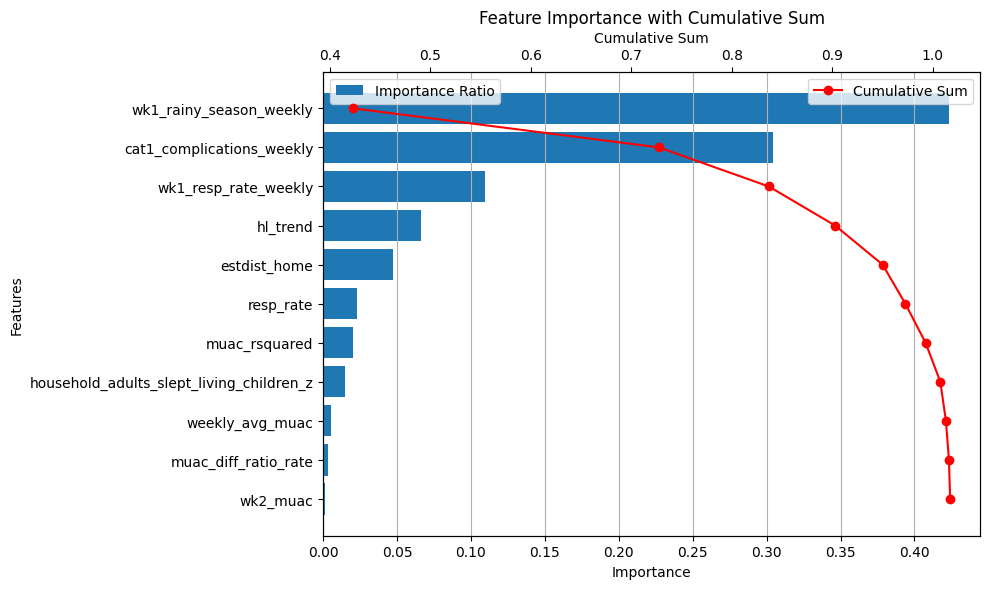

In [25]:
autogluon_feature_importance = predictor.feature_importance(
    test_data2, subsample_size=1000, time_limit=400
)
autogluon_feature_importance["cumsum"] = (
    autogluon_feature_importance["importance"].cumsum()
    / autogluon_feature_importance["importance"].sum()
)
autogluon_feature_importance["importance_ratio"] = (
    autogluon_feature_importance["importance"]
    / autogluon_feature_importance["importance"].sum()
)
autogluon_feature_importance[["cumsum", "importance_ratio"]]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot on the primary y-axis
autogluon_feature_importance_filtered = autogluon_feature_importance[
    autogluon_feature_importance["importance"] > 0
]
ax1.barh(
    autogluon_feature_importance_filtered.index,
    autogluon_feature_importance_filtered["importance_ratio"],
    label="Importance Ratio",
)
ax1.set_xlabel("Importance")
ax1.set_ylabel("Features")
ax1.set_title("Feature Importance with Cumulative Sum")
ax1.legend(loc="upper left")  # specify location for the first legend
ax1.grid(True, axis="x")  # gridlines only on the x-axis for the bar plot
ax1.invert_yaxis()

# Create a secondary y-axis
ax2 = ax1.twiny()

# Line plot on the secondary y-axis
ax2.plot(
    autogluon_feature_importance_filtered["cumsum"],
    autogluon_feature_importance_filtered.index,
    marker="o",
    linestyle="-",
    color="red",
    label="Cumulative Sum",
)
ax2.set_xlabel("Cumulative Sum")
ax2.legend(loc="upper right")  # specify location for the second legend

# Improve layout
fig.tight_layout()
plt.show()

0.1.0 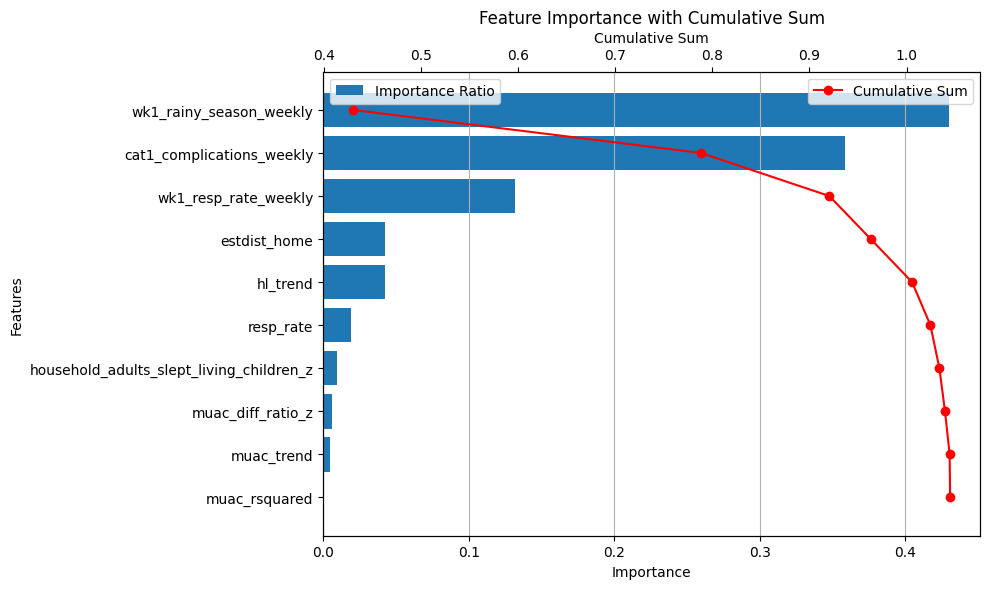

## export the AG model

In [26]:
VERSION = "0.1.0"

metadata = {
    "version": VERSION,
    "inputs": autogluon_feature_importance.sort_values(
        by="importance", ascending=False
    ).index.tolist(),
    "outputs": "chance of new onset medical complication, referral to inpatient treatment with a cat1 medical severity",
    "description": (
        "Predicts chance of new onset medical complication health complication  given the latest 3 weeks of patient weekly (raw and processed) data plus their admission data.  Medical complication is defined as a 'cat1' complication (see vars in raw ODK data with cat1_ prefix)"
    ),
    "feature_engineering": (
        "<household_adults_slept_living_children_z> is a one-dimension PCA reduction of the normalized values of ['household_adults','household_slept','living_children'] <muac_diff_ratio_z> is a similar reduction of ['muac_diff_ratio','muac'] which are muac change per day over the patient's treatment ((latest muac - first muac)/days in program) and their admittance muac"
    ),
    "contact": "Brian Chaplin",
}

path = f"{MODEL_DIR}{label}not1/{VERSION}/model.tar.gz"

do_storage.to_autogluon_tarball(predictor, model_metadata=metadata, path=path)

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/hunter.merrill/dev/repos/health-predictions/taimaka_health_predictions/train/AutogluonModels/new_onset_medical_complication")
